### Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
from matplotlib import style

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

from collections import Counter
import re

: 

### Load the data

In [2]:
df = pd.read_csv('tinubu.csv')

In [3]:
save_df = pd.read_csv('tinubu.csv')
save_df.head()

,Unnamed: 0,date,user,source,tweet,location,like_count,retweet_count
0,0,2022-11-29 23:50:47+00:00,Omo_Oye2,Twitter for iPhone,PHOTOS: Director of the Fundraising Committee ...,Bourdillon,1,1
1,1,2022-11-29 20:14:56+00:00,KunleGbolu,Twitter for Android,Even Peter Obi no fit do shingbaine as preside...,"Lagos, Nigeria",0,0
2,2,2022-11-29 20:03:39+00:00,akomscopy,Twitter for Android,day 8. \nIBEJU LEKKI LG:\n DATE: WEDNESDAY (...,"Lagos, Nigeria",5,2
3,3,2022-11-29 19:38:11+00:00,duwdu,Twitter for Android,@GwarzoIlyasu May d trip be blessed &amp; star...,NaN,2,0
4,4,2022-11-29 19:38:01+00:00,duwdu,Twitter for Android,May d trip be blessed &amp; stars aligned towa...,NaN,1,0


In [4]:
df = df.iloc[:, 1:]
df.head()

,date,user,source,tweet,location,like_count,retweet_count
0,2022-11-29 23:50:47+00:00,Omo_Oye2,Twitter for iPhone,PHOTOS: Director of the Fundraising Committee ...,Bourdillon,1,1
1,2022-11-29 20:14:56+00:00,KunleGbolu,Twitter for Android,Even Peter Obi no fit do shingbaine as preside...,"Lagos, Nigeria",0,0
2,2022-11-29 20:03:39+00:00,akomscopy,Twitter for Android,day 8. \nIBEJU LEKKI LG:\n DATE: WEDNESDAY (...,"Lagos, Nigeria",5,2
3,2022-11-29 19:38:11+00:00,duwdu,Twitter for Android,@GwarzoIlyasu May d trip be blessed &amp; star...,NaN,2,0
4,2022-11-29 19:38:01+00:00,duwdu,Twitter for Android,May d trip be blessed &amp; stars aligned towa...,NaN,1,0


### Inspect the data

In [5]:
df.shape

(10001, 7)

In [6]:
df.isna().sum()

date                0
user                0
source              0
tweet               0
location         2116
like_count          0
retweet_count       0
dtype: int64

In [7]:
len(df.user.unique())

3572

In [8]:
len(df.source.unique())

23

In [9]:
len(df.location.unique())

997

### Inspect trending hashtags

In [10]:
def hashtag(tweet):
    tags = re.findall(r'#(\w+)', tweet)
    return ' '.join(tags)

In [11]:
df['hashtags'] = df['tweet'].apply(hashtag)
df.head(5)

,date,user,source,tweet,location,like_count,retweet_count,hashtags
0,2022-11-29 23:50:47+00:00,Omo_Oye2,Twitter for iPhone,PHOTOS: Director of the Fundraising Committee ...,Bourdillon,1,1,BAT2023
1,2022-11-29 20:14:56+00:00,KunleGbolu,Twitter for Android,Even Peter Obi no fit do shingbaine as preside...,"Lagos, Nigeria",0,0,BAT2023 RenewedHope2023 GETYOURPVC
2,2022-11-29 20:03:39+00:00,akomscopy,Twitter for Android,day 8. \nIBEJU LEKKI LG:\n DATE: WEDNESDAY (...,"Lagos, Nigeria",5,2,BAT2023 Asiwaju agbadoeconomy
3,2022-11-29 19:38:11+00:00,duwdu,Twitter for Android,@GwarzoIlyasu May d trip be blessed &amp; star...,NaN,2,0,BAT2023
4,2022-11-29 19:38:01+00:00,duwdu,Twitter for Android,May d trip be blessed &amp; stars aligned towa...,NaN,1,0,BAT2023


In [12]:
hashtags_list = df['hashtags'].tolist()

hashtags = []
for item in hashtags_list:
    item = item.split()
    for i in item:
        hashtags.append(i)

        
counts = Counter(hashtags)
hashtags_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
hashtags_df.columns = ['Hashtags', 'Count']
hashtags_df.sort_values(by='Count', ascending=False, inplace=True)

In [13]:
top_ten = hashtags_df.head(10)
top_ten.head()

,Hashtags,Count
0,BAT2023,9158
28,BATKSM2023,732
1,RenewedHope2023,551
54,TinubuShettima2023,497
72,Tinubu2023,440


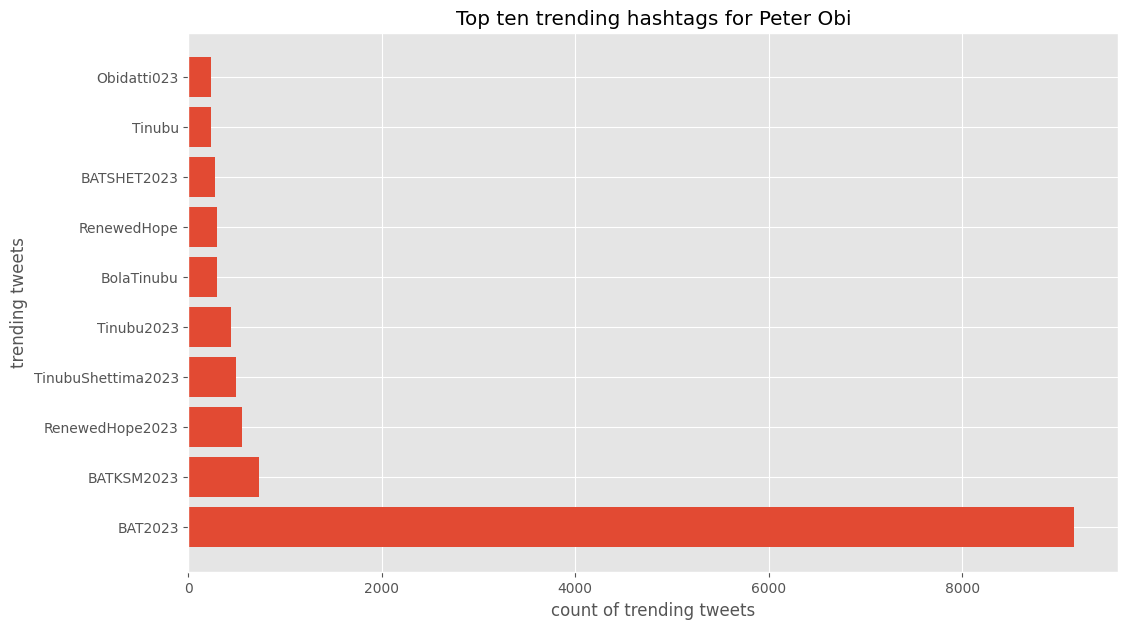

In [14]:
style.use('ggplot')
plt.figure(figsize=(12,7))
plt.barh(top_ten.Hashtags, top_ten.Count)
plt.ylabel('trending tweets')
plt.xlabel('count of trending tweets')
plt.title('Top ten trending hashtags for Peter Obi')
plt.show()

### Data cleaning and preprocessing

In [15]:
def clean_tweet(text):
    text = re.sub(r'#[A-Za-z0-9^\w]+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
#     text = re.sub(r'[^\w]', ' ', text)
    
    return text

In [16]:
def preprocess(text):
    preprocessed_text = []
    for t in text.split():
        if len(t) > 1:
            t = '@user' if t[0] == '@' and t.count('@') == 1 else t
            t = 'http' if t.startswith('http') else t
        preprocessed_text.append(t)
    return ' '.join(preprocessed_text)

In [17]:
df['tweet'] = df['tweet'].apply(preprocess)

for i, j in enumerate(df['tweet']):
    print(i, j, '\n')
    if i > 5:
        break

0 PHOTOS: Director of the Fundraising Committee of the PCC, and Vice Presidential Candidate, Sen. Kashim Shettima, the Lagos State Governor, Babajide Sanwo-Olu unveil the Crowdfunding App for the APC Presidential Campaign 2023 at the Civic Centre, Victoria Island, Lagos. #BAT2023 http 

1 Even Peter Obi no fit do shingbaine as president ask me why, him first 4yrs him go repeat the process of trying to stabilize... As Buhari don Stabilized make #BAT2023 start work #RenewedHope2023 #GETYOURPVC 

2 day 8. IBEJU LEKKI LG: DATE: WEDNESDAY (14/12/2022) VENUE: SUPPLIER HALL, ELEKO JUNCTION, OPPOSITE TOTAL PETROL STATION, IBEJU LEKKI, LAGOS. #BAT2023 #Asiwaju #agbadoeconomy 

3 @user May d trip be blessed &amp; stars aligned towards d resounding victory from Feb 25, 2023, for d @officialABAT-@KashimSM #BAT2023 presidency project, on d @user SPV. D Almighty willing &amp; sparing us all, d victory shall usher into 🇳🇬 an era of uncommon economic growth &amp; peace. 

4 May d trip be blessed &amp;

In [18]:
df['tweet'] = df['tweet'].apply(clean_tweet)

for i, j in enumerate(df['tweet']):
    print(i, j, '\n')
    if i > 5:
        break

0 PHOTOS: Director of the Fundraising Committee of the PCC, and Vice Presidential Candidate, Sen. Kashim Shettima, the Lagos State Governor, Babajide Sanwo-Olu unveil the Crowdfunding App for the APC Presidential Campaign 2023 at the Civic Centre, Victoria Island, Lagos.  http 

1 Even Peter Obi no fit do shingbaine as president ask me why, him first 4yrs him go repeat the process of trying to stabilize... As Buhari don Stabilized make  start work   

2 day 8. IBEJU LEKKI LG: DATE: WEDNESDAY (14/12/2022) VENUE: SUPPLIER HALL, ELEKO JUNCTION, OPPOSITE TOTAL PETROL STATION, IBEJU LEKKI, LAGOS.    

3 @user May d trip be blessed &amp; stars aligned towards d resounding victory from Feb 25, 2023, for d @officialABAT-@KashimSM  presidency project, on d @user SPV. D Almighty willing &amp; sparing us all, d victory shall usher into 🇳🇬 an era of uncommon economic growth &amp; peace. 

4 May d trip be blessed &amp; stars aligned towards d resounding victory from Feb 25, 2023, for d @officialABA

### Tweet labelling using Pre-trained Roberta (Transformer Model)

In [19]:
roberta = 'cardiffnlp/twitter-roberta-base-sentiment'
model = AutoModelForSequenceClassification.from_pretrained(roberta, from_tf=True)
tokenizer = AutoTokenizer.from_pretrained(roberta)

All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


In [20]:
from transformers import pipeline

In [21]:
sentiment_task = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

### Working on full dataset

In [22]:
df.head()

,date,user,source,tweet,location,like_count,retweet_count,hashtags
0,2022-11-29 23:50:47+00:00,Omo_Oye2,Twitter for iPhone,PHOTOS: Director of the Fundraising Committee ...,Bourdillon,1,1,BAT2023
1,2022-11-29 20:14:56+00:00,KunleGbolu,Twitter for Android,Even Peter Obi no fit do shingbaine as preside...,"Lagos, Nigeria",0,0,BAT2023 RenewedHope2023 GETYOURPVC
2,2022-11-29 20:03:39+00:00,akomscopy,Twitter for Android,day 8. IBEJU LEKKI LG: DATE: WEDNESDAY (14/12/...,"Lagos, Nigeria",5,2,BAT2023 Asiwaju agbadoeconomy
3,2022-11-29 19:38:11+00:00,duwdu,Twitter for Android,@user May d trip be blessed &amp; stars aligne...,NaN,2,0,BAT2023
4,2022-11-29 19:38:01+00:00,duwdu,Twitter for Android,May d trip be blessed &amp; stars aligned towa...,NaN,1,0,BAT2023


In [23]:
df.shape

(10001, 8)

In [24]:
full_analysis = sentiment_task(df['tweet'].tolist())

In [25]:
full_analysis

[{'label': 'LABEL_1', 'score': 0.9276247620582581},
 {'label': 'LABEL_1', 'score': 0.5322450995445251},
 {'label': 'LABEL_1', 'score': 0.8942791819572449},
 {'label': 'LABEL_2', 'score': 0.9393718242645264},
 {'label': 'LABEL_2', 'score': 0.947179913520813},
 {'label': 'LABEL_1', 'score': 0.5571970343589783},
 {'label': 'LABEL_1', 'score': 0.5555456280708313},
 {'label': 'LABEL_2', 'score': 0.49363163113594055},
 {'label': 'LABEL_1', 'score': 0.5826759338378906},
 {'label': 'LABEL_1', 'score': 0.5318455696105957},
 {'label': 'LABEL_1', 'score': 0.9276247620582581},
 {'label': 'LABEL_1', 'score': 0.9276247620582581},
 {'label': 'LABEL_2', 'score': 0.9580767750740051},
 {'label': 'LABEL_1', 'score': 0.8687261939048767},
 {'label': 'LABEL_2', 'score': 0.6393022537231445},
 {'label': 'LABEL_1', 'score': 0.6415360569953918},
 {'label': 'LABEL_0', 'score': 0.66712886095047},
 {'label': 'LABEL_1', 'score': 0.5772413611412048},
 {'label': 'LABEL_1', 'score': 0.9152712225914001},
 {'label': 'LA

In [26]:
len(full_analysis)

10001

In [27]:
count = 0
for i in full_analysis:
    df.loc[count, 'sentiment'] = full_analysis[count]['label']
    df.loc[count, 'score'] = full_analysis[count]['score']
    count += 1

In [28]:
df.head()

,date,user,source,tweet,location,like_count,retweet_count,hashtags,sentiment,score
0,2022-11-29 23:50:47+00:00,Omo_Oye2,Twitter for iPhone,PHOTOS: Director of the Fundraising Committee ...,Bourdillon,1,1,BAT2023,LABEL_1,0.927625
1,2022-11-29 20:14:56+00:00,KunleGbolu,Twitter for Android,Even Peter Obi no fit do shingbaine as preside...,"Lagos, Nigeria",0,0,BAT2023 RenewedHope2023 GETYOURPVC,LABEL_1,0.532245
2,2022-11-29 20:03:39+00:00,akomscopy,Twitter for Android,day 8. IBEJU LEKKI LG: DATE: WEDNESDAY (14/12/...,"Lagos, Nigeria",5,2,BAT2023 Asiwaju agbadoeconomy,LABEL_1,0.894279
3,2022-11-29 19:38:11+00:00,duwdu,Twitter for Android,@user May d trip be blessed &amp; stars aligne...,NaN,2,0,BAT2023,LABEL_2,0.939372
4,2022-11-29 19:38:01+00:00,duwdu,Twitter for Android,May d trip be blessed &amp; stars aligned towa...,NaN,1,0,BAT2023,LABEL_2,0.947180


In [29]:
df.sentiment.value_counts()

LABEL_1    5762
LABEL_2    2665
LABEL_0    1574
Name: sentiment, dtype: int64

In [30]:
sentiment_names = {
                    'LABEL_0': 'negative',
                    'LABEL_1': 'neutral',
                    'LABEL_2': 'positive'
}

df['sentiment'] = df['sentiment'].map(sentiment_names)

In [31]:
df.head()

,date,user,source,tweet,location,like_count,retweet_count,hashtags,sentiment,score
0,2022-11-29 23:50:47+00:00,Omo_Oye2,Twitter for iPhone,PHOTOS: Director of the Fundraising Committee ...,Bourdillon,1,1,BAT2023,neutral,0.927625
1,2022-11-29 20:14:56+00:00,KunleGbolu,Twitter for Android,Even Peter Obi no fit do shingbaine as preside...,"Lagos, Nigeria",0,0,BAT2023 RenewedHope2023 GETYOURPVC,neutral,0.532245
2,2022-11-29 20:03:39+00:00,akomscopy,Twitter for Android,day 8. IBEJU LEKKI LG: DATE: WEDNESDAY (14/12/...,"Lagos, Nigeria",5,2,BAT2023 Asiwaju agbadoeconomy,neutral,0.894279
3,2022-11-29 19:38:11+00:00,duwdu,Twitter for Android,@user May d trip be blessed &amp; stars aligne...,NaN,2,0,BAT2023,positive,0.939372
4,2022-11-29 19:38:01+00:00,duwdu,Twitter for Android,May d trip be blessed &amp; stars aligned towa...,NaN,1,0,BAT2023,positive,0.947180


In [32]:
df.sentiment.value_counts()

neutral     5762
positive    2665
negative    1574
Name: sentiment, dtype: int64

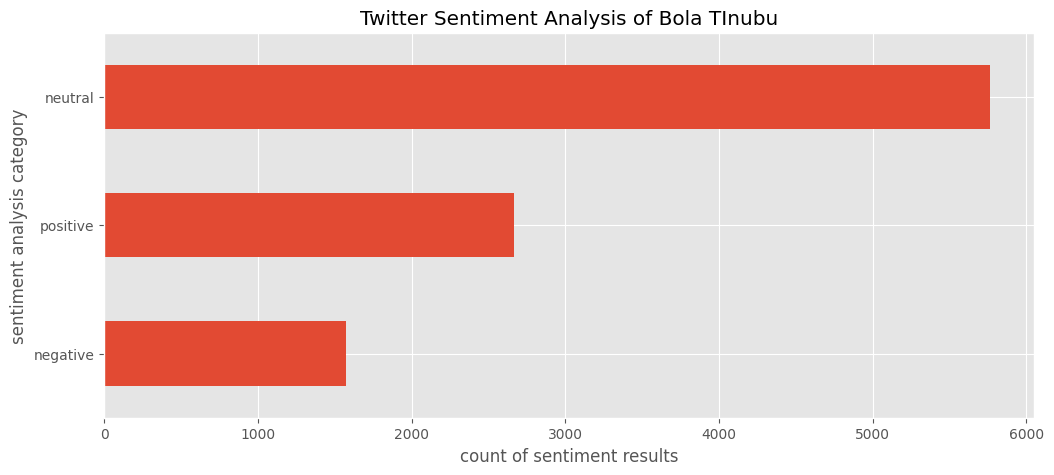

In [35]:
style.use('ggplot')
plt.figure(figsize=(12,5))
df.sentiment.value_counts().sort_values().plot(kind='barh')
plt.ylabel('sentiment analysis category')
plt.xlabel('count of sentiment results')
plt.title('Twitter Sentiment Analysis of Bola TInubu')
plt.show()

In [36]:
tinubu_df = df[['tweet', 'sentiment', 'score', 'location', 'hashtags']]

In [37]:
tinubu_df.head()

,tweet,sentiment,score,location,hashtags
0,PHOTOS: Director of the Fundraising Committee ...,neutral,0.927625,Bourdillon,BAT2023
1,Even Peter Obi no fit do shingbaine as preside...,neutral,0.532245,"Lagos, Nigeria",BAT2023 RenewedHope2023 GETYOURPVC
2,day 8. IBEJU LEKKI LG: DATE: WEDNESDAY (14/12/...,neutral,0.894279,"Lagos, Nigeria",BAT2023 Asiwaju agbadoeconomy
3,@user May d trip be blessed &amp; stars aligne...,positive,0.939372,NaN,BAT2023
4,May d trip be blessed &amp; stars aligned towa...,positive,0.947180,NaN,BAT2023


In [38]:
tinubu_df.to_csv('labelled_tinubu.csv')

In [39]:
j = 1
sorted_df = df.sort_values(by=['score'])
for i in range(0, sorted_df.shape[0]):
    if sorted_df['sentiment'][i] == 'positive':
        print(str(j) + ') ' + sorted_df['tweet'][i])
        print()
        j = j + 1

1) @user May d trip be blessed &amp; stars aligned towards d resounding victory from Feb 25, 2023, for d @officialABAT-@KashimSM  presidency project, on d @user SPV. D Almighty willing &amp; sparing us all, d victory shall usher into 🇳🇬 an era of uncommon economic growth &amp; peace.

2) May d trip be blessed &amp; stars aligned towards d resounding victory from Feb 25, 2023, for d @officialABAT-@KashimSM  presidency project, on d @user SPV. D Almighty willing &amp; sparing us all, d victory shall usher into 🇳🇬 an era of uncommon economic growth &amp; peace. http

3) The BAT mandate is the ultimate goal.  http

4)  🇳🇬🙌🏼😍 http

5) God's choice for Nigeria 🇳🇬.   http

6) I'm proudly an APC supporter.  http

7) “Tinubu is the builder of the modern Lagos we are all enjoying today. For implementing his vision through character and tenacity, and pushing his ideas to what we can physically see, our candidate is the best choice for the president.” ~ Babajide Sanwoolu   http

8) Honestly, you t

In [40]:
j = 1
sorted_df = df.sort_values(by=['score'])
for i in range(0, sorted_df.shape[0]):
    if sorted_df['sentiment'][i] == 'neutral':
        print(str(j) + ') ' + sorted_df['tweet'][i])
        print()
        j = j + 1

1) PHOTOS: Director of the Fundraising Committee of the PCC, and Vice Presidential Candidate, Sen. Kashim Shettima, the Lagos State Governor, Babajide Sanwo-Olu unveil the Crowdfunding App for the APC Presidential Campaign 2023 at the Civic Centre, Victoria Island, Lagos.  http

2) Even Peter Obi no fit do shingbaine as president ask me why, him first 4yrs him go repeat the process of trying to stabilize... As Buhari don Stabilized make  start work  

3) day 8. IBEJU LEKKI LG: DATE: WEDNESDAY (14/12/2022) VENUE: SUPPLIER HALL, ELEKO JUNCTION, OPPOSITE TOTAL PETROL STATION, IBEJU LEKKI, LAGOS.   

4)     http

5) Nigeria is not for sale, doesn't need a speculator to sell your assets from day one. Nigeria isn't an experimental market, doesn't need a Market to Market Manager(MMM). Nigeria is a project, needs a nation builder who knows what to do from day one and will add value. 🇳🇬  http

6) @user Lord of Moses Lord of Abraham Lord of Jesus Christ and the Lord of Prophet Muhammad (pbu-them

In [41]:
j = 1
sorted_df = df.sort_values(by=['score'])
for i in range(0, sorted_df.shape[0]):
    if sorted_df['sentiment'][i] == 'negative':
        print(str(j) + ') ' + sorted_df['tweet'][i])
        print()
        j = j + 1

1) In case you don't know, the way you feel right now with this PO thing, is the way Boko Haram and bandits feels. I believe with the right motivation, most of you will carry gun and kill people... ... Heaven won't fall, we plenty pass you...

2)    why u will not vote apc http

3) @user Am a product of  but Ganduje has kill APC and is still working to kill it again 

4) The forerunners in the  campaign are a rapacious lot who chose to be silent &amp; ignore the devastations of their people, especially the Far Up Country Progressive Governors whose people are victims of armed banditry, impoverishment &amp; starvation. Do we feed from your crumbs?

5) @user @user @user Stop this na Come on Don't give in to despair  

6) @user @user @user @user @user Good governance would settle your miserable acts Wait for it  

7) If truly Peter Obi cares about our economy, he mustn't become president to fix that. Asiwaju Bola Ahmed Tinubu can appoint him as finance minister or cbn governor or whatever